In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras.preprocessing.image
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import os;
import datetime
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

classifier = Sequential()

In [ ]:
x_images = np.load('/content/X.npy')

# load labels of shape (5547,1); (0 = no cancer, 1 = cancer)
y_images = np.load('/content/Y.npy')

# shuffle data
perm_array = np.arange(len(x_images))
np.random.shuffle(perm_array)
x_images = x_images[perm_array]
y_images = y_images[perm_array]

print('x_images.shape =', x_images.shape)
print('x_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images.min(),
                        x_images.mean(), x_images.std(), x_images.max()))
print('')
print('y_images.shape =', y_images.shape)
print('y_images.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_images.min(),
                        y_images.mean(), y_images.std(), y_images.max()))

x_images.shape = (5547, 50, 50, 3)
x_images.min/mean/std/max = 2.00/185.36/47.29/255.00

y_images.shape = (5547,)
y_images.min/mean/std/max = 0.00/0.50/0.50/1.00


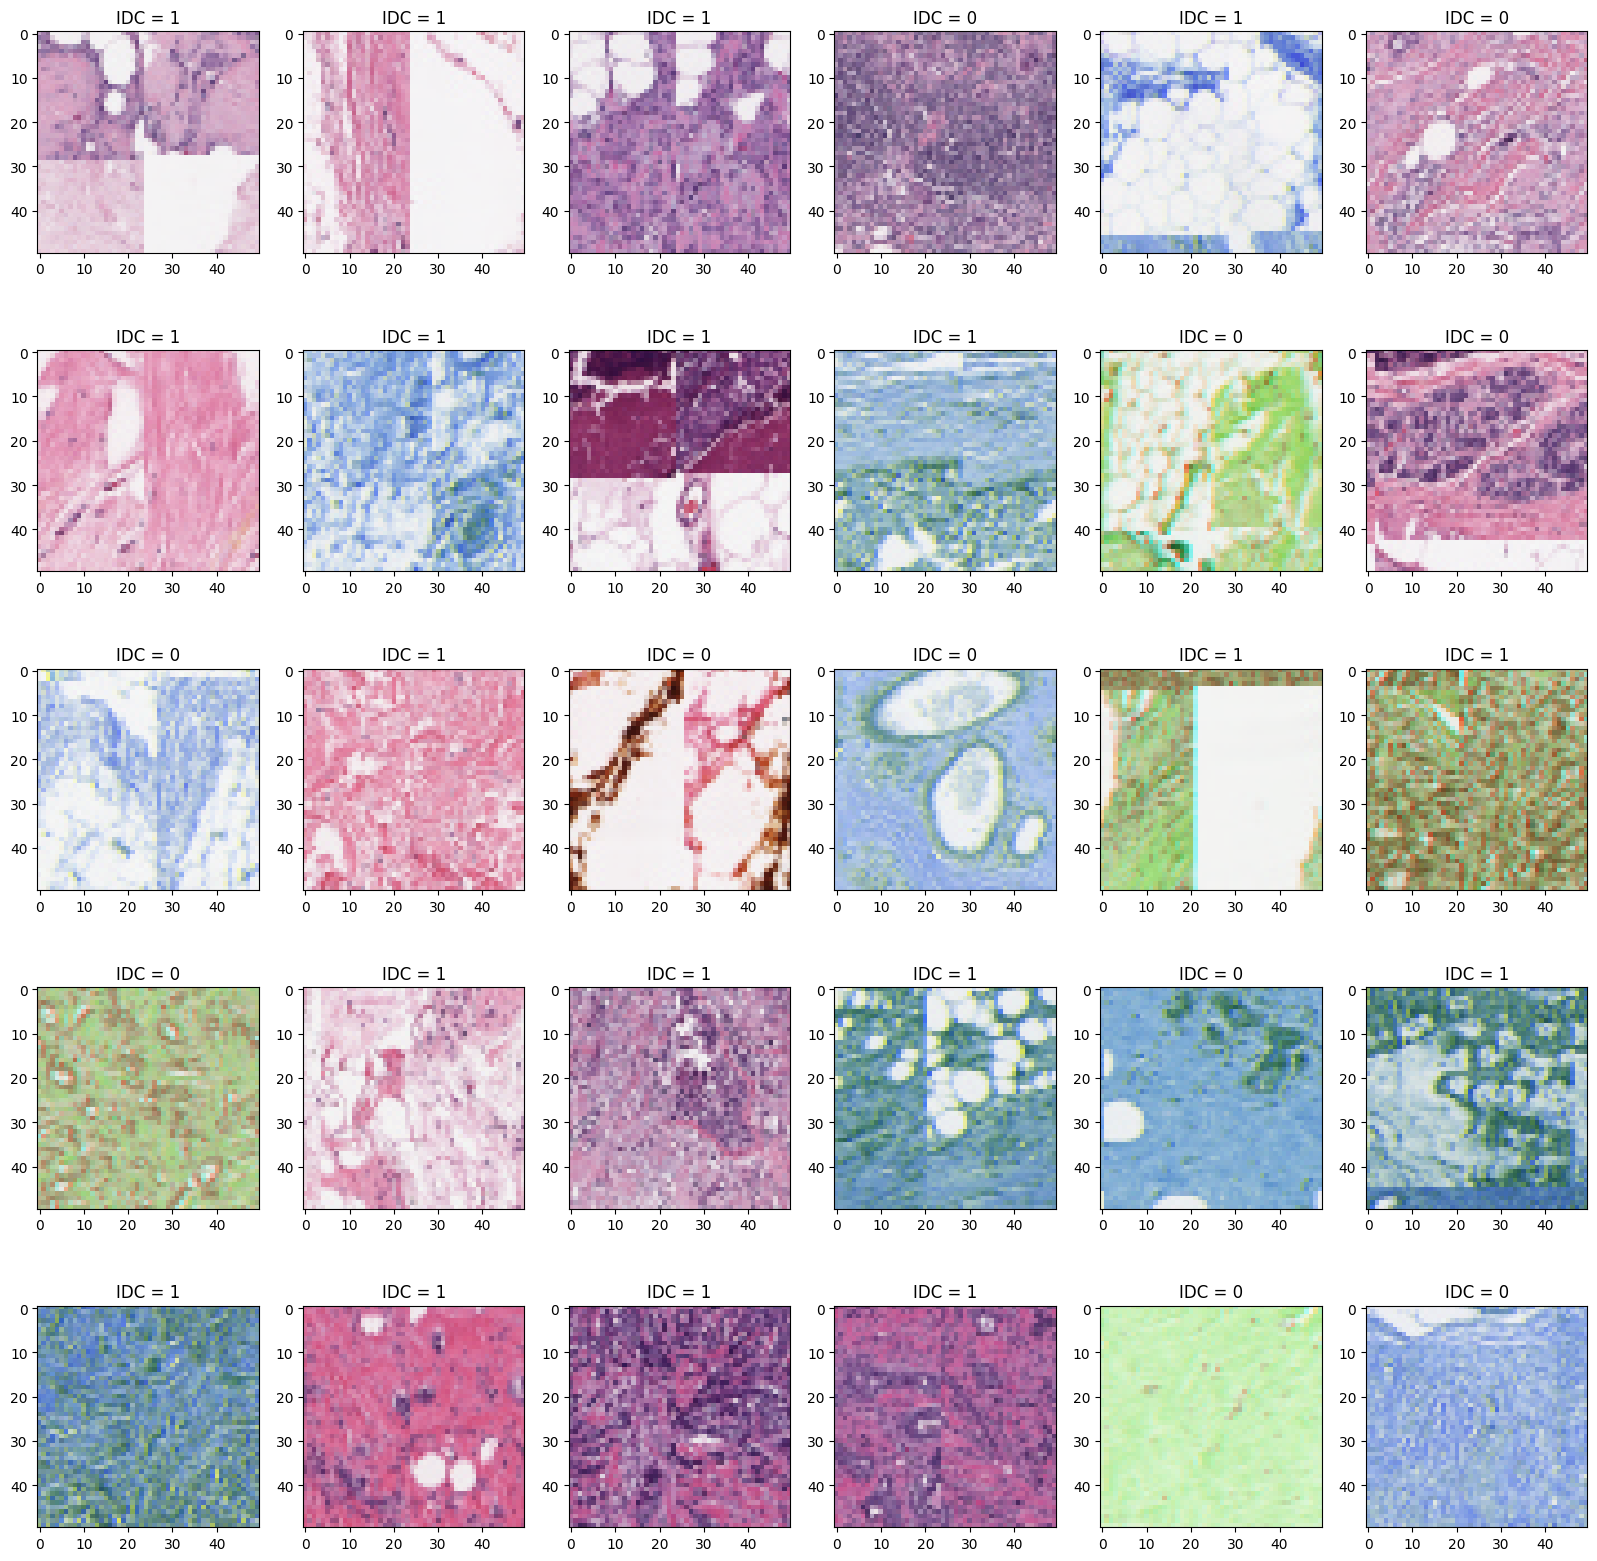

In [ ]:
imgs_0 = x_images[y_images == 0] # 0 = no cancer
imgs_1 = x_images[y_images == 1] # 1 = cancer

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%y_images[i])
    plt.imshow(x_images[i])

red channel: min/mean/std/max = 5.00/188.56/46.12/255.00
green channel: min/mean/std/max = 2.00/180.57/49.90/255.00
blue channel: min/mean/std/max = 4.00/186.96/45.36/255.00


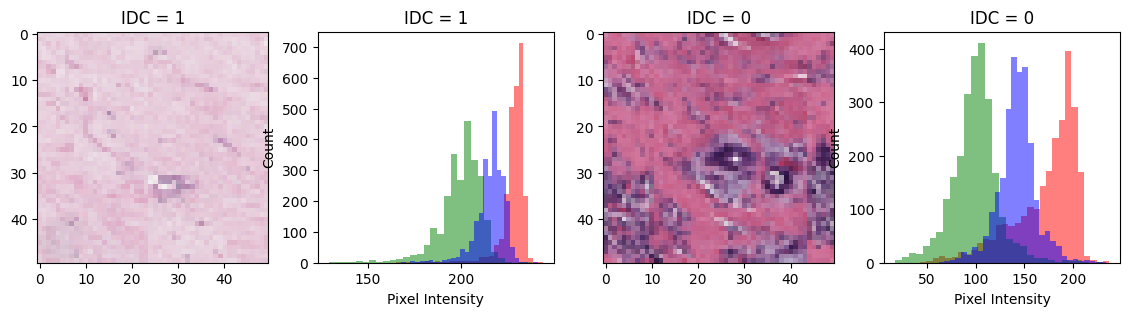

In [ ]:
plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(x_images))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.imshow(x_images[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%y_images[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(x_images[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(x_images[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(x_images[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);

print('red channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,0].min(),
    x_images[:,:,:,0].mean(), x_images[:,:,:,0].std(), x_images[:,:,:,0].max()))
print('green channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,1].min(),
    x_images[:,:,:,1].mean(), x_images[:,:,:,1].std(), x_images[:,:,:,1].max()))
print('blue channel: min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_images[:,:,:,2].min(),
    x_images[:,:,:,2].mean(), x_images[:,:,:,2].std(), x_images[:,:,:,2].max()))

In [ ]:
## normalize data

# convert one-hot encodings into labels
def one_hot_to_dense(labels_one_hot):
    return np.argmax(labels_one_hot,1)

# convert class labels from scalars to one-hot vectors e.g. 1 => [0 1], 0 => [1 0]
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
    return labels_one_hot

# function to normalize data
def normalize_data(data):
    # scale features using statistics that are robust to outliers
    #rs = sklearn.preprocessing.RobustScaler()
    #rs.fit(data)
    #data = rs.transform(data)
    #data = (data-data.mean())/(data.std()) # standardisation
    data = data / data.max() # convert from [0:255] to [0.:1.]
    #data = ((data / 255.)-0.5)*2. # convert from [0:255] to [-1.:+1.]
    return data

# training and validation data
x_train_valid = normalize_data(x_images)

# use one-hot encoding for labels 0,1
y_train_valid = dense_to_one_hot(y_images, 2).astype(np.uint8)

# dictionaries for saving results
y_valid_pred = {}
y_train_pred = {}
y_test_pred = {}
train_loss, valid_loss = {}, {}
train_acc, valid_acc = {}, {}
cnf_valid_matrix = {}

print('x_train_valid.shape =', x_train_valid.shape)
print('x_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(x_train_valid.min(),
                        x_train_valid.mean(), x_train_valid.std(), x_train_valid.max()))
print('')
print('y_train_valid.shape =', y_train_valid.shape)
print('y_train_valid.min/mean/std/max = %.2f/%.2f/%.2f/%.2f'%(y_train_valid.min(),
                        y_train_valid.mean(), y_train_valid.std(), y_train_valid.max()))

x_train_valid.shape = (5547, 50, 50, 3)
x_train_valid.min/mean/std/max = 0.01/0.73/0.19/1.00

y_train_valid.shape = (5547, 2)
y_train_valid.min/mean/std/max = 0.00/0.50/0.50/1.00


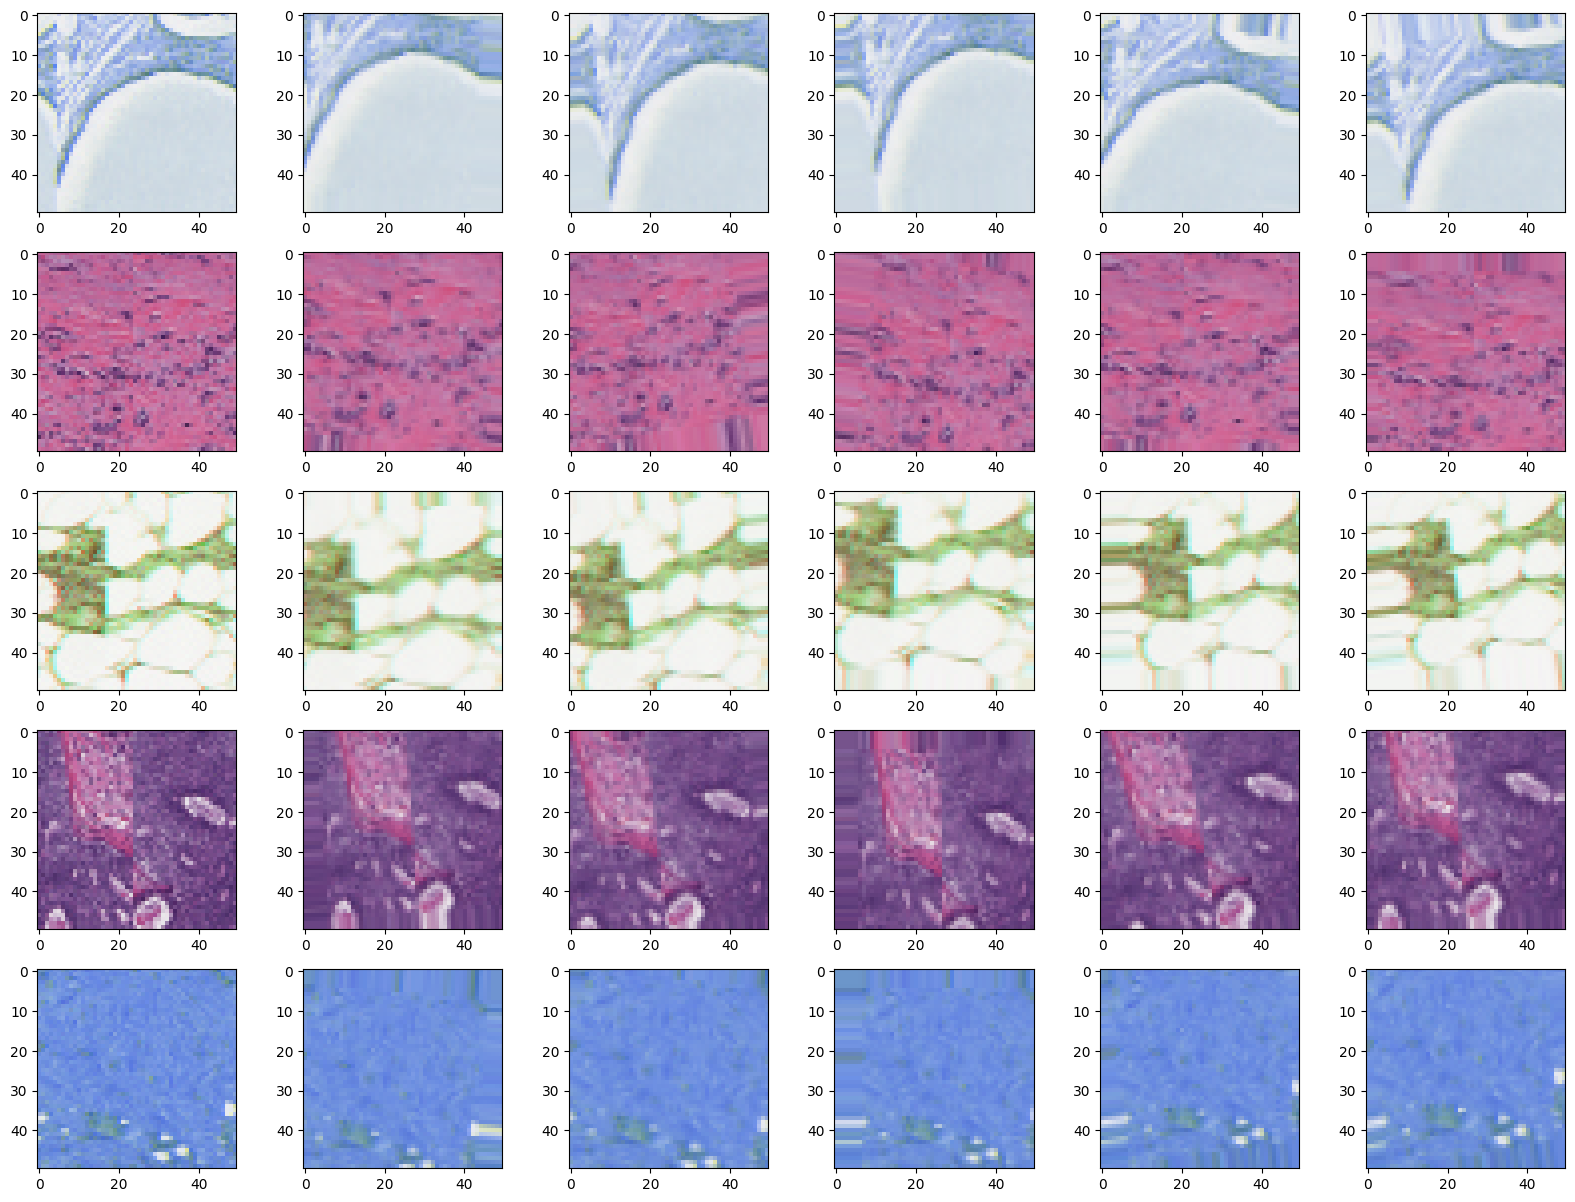

In [ ]:
def generate_images(imgs):

    # rotations, translations, zoom
    image_generator = keras.preprocessing.image.ImageDataGenerator(
        rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
        zoom_range = 0.1)

    # get transformed images
    imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                batch_size=len(imgs), shuffle = False).next()
    return imgs[0]

# check image generation
fig,axs = plt.subplots(5,6, figsize=(20,15))
for i in range(5):
    n = np.random.randint(0,x_images.shape[0]-2)
    axs[i,0].imshow(x_images[n])
    axs[i,1].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,2].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,3].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,4].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))
    axs[i,5].imshow(generate_images(x_images[n:n+1])[0].astype('uint8'))

In [ ]:
## First try out some basic sklearn models

# computet the accuracy of label predictions
def accuracy_from_dense_labels(y_target, y_pred):
    y_target = y_target.reshape(-1,)
    y_pred = y_pred.reshape(-1,)
    return np.mean(y_target == y_pred)

logreg = sklearn.linear_model.LogisticRegression(verbose=0, solver='lbfgs',
                                                 multi_class = 'multinomial')
decision_tree = sklearn.tree.DecisionTreeClassifier()
extra_trees = sklearn.ensemble.ExtraTreesClassifier(verbose=0, max_depth=4)
gradient_boost = sklearn.ensemble.GradientBoostingClassifier(verbose=0)
random_forest = sklearn.ensemble.RandomForestClassifier(verbose=0, max_depth=4, n_estimators=10)
gaussianNB = sklearn.naive_bayes.GaussianNB()


# store models in dictionary
base_models = {'logreg': logreg, 'extra_trees': extra_trees,
               'gradient_boost': gradient_boost, 'random_forest': random_forest,
               'decision_tree': decision_tree, 'gaussianNB': gaussianNB}

# choose models for out-of-folds predictions
#take_models = ['logreg','random_forest','extra_trees','gaussianNB']
take_models = ['logreg', 'random_forest', 'extra_trees', 'gaussianNB']

for mn in take_models:
    train_acc[mn] = []
    valid_acc[mn] = []
    cnf_valid_matrix[mn] = []

# start timer
start = datetime.datetime.now();
print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True) #, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index].reshape(-1,7500)
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index].reshape(-1,7500)
    y_valid = y_train_valid[valid_index]

    for mn in take_models:

        # create cloned model from base models
        model = sklearn.base.clone(base_models[mn])
        model.fit(x_train, one_hot_to_dense(y_train))

        # predictions
        y_train_pred[mn] = model.predict_proba(x_train)
        y_valid_pred[mn] = model.predict_proba(x_valid)

        # accuracies
        train_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_train_pred[mn]),
                                                        one_hot_to_dense(y_train)))
        valid_acc[mn].append(accuracy_from_dense_labels(one_hot_to_dense(y_valid_pred[mn]),
                                                        one_hot_to_dense(y_valid)))

        # normalized confusion matrix
        cnf_valid_matrix_tmp = sklearn.metrics.confusion_matrix(
            y_pred = one_hot_to_dense(y_valid_pred[mn]),
            y_true = one_hot_to_dense(y_valid)).astype(np.float32)
        cnf_valid_matrix_tmp[0,:] = cnf_valid_matrix_tmp[0,:]/cnf_valid_matrix_tmp[0,:].sum()
        cnf_valid_matrix_tmp[1,:] = cnf_valid_matrix_tmp[1,:]/cnf_valid_matrix_tmp[1,:].sum()
        cnf_valid_matrix[mn].append(cnf_valid_matrix_tmp)

        print(i,': '+mn+' train/valid accuracy = %.3f/%.3f'%(train_acc[mn][-1],
                                                             valid_acc[mn][-1]))

print('running time for training: ', datetime.datetime.now() - start)
print('')
for mn in train_acc.keys():
    print(mn + ' : averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                              np.mean(valid_acc[mn])))

08-05-2024 11:56:57 : start training


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0 : logreg train/valid accuracy = 0.840/0.571
0 : random_forest train/valid accuracy = 0.678/0.650
0 : extra_trees train/valid accuracy = 0.675/0.659
0 : gaussianNB train/valid accuracy = 0.618/0.645


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


1 : logreg train/valid accuracy = 0.850/0.578
1 : random_forest train/valid accuracy = 0.681/0.663
1 : extra_trees train/valid accuracy = 0.673/0.643
1 : gaussianNB train/valid accuracy = 0.625/0.600


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


2 : logreg train/valid accuracy = 0.922/0.541
2 : random_forest train/valid accuracy = 0.677/0.649
2 : extra_trees train/valid accuracy = 0.670/0.654
2 : gaussianNB train/valid accuracy = 0.618/0.640


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


3 : logreg train/valid accuracy = 0.868/0.600
3 : random_forest train/valid accuracy = 0.680/0.668
3 : extra_trees train/valid accuracy = 0.671/0.676
3 : gaussianNB train/valid accuracy = 0.617/0.613


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


4 : logreg train/valid accuracy = 0.855/0.580
4 : random_forest train/valid accuracy = 0.689/0.605
4 : extra_trees train/valid accuracy = 0.677/0.598
4 : gaussianNB train/valid accuracy = 0.623/0.591


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


5 : logreg train/valid accuracy = 0.849/0.620
5 : random_forest train/valid accuracy = 0.684/0.641
5 : extra_trees train/valid accuracy = 0.676/0.636
5 : gaussianNB train/valid accuracy = 0.619/0.613


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


6 : logreg train/valid accuracy = 0.876/0.609
6 : random_forest train/valid accuracy = 0.682/0.661
6 : extra_trees train/valid accuracy = 0.679/0.645
6 : gaussianNB train/valid accuracy = 0.620/0.620


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


7 : logreg train/valid accuracy = 0.841/0.619
7 : random_forest train/valid accuracy = 0.683/0.664
7 : extra_trees train/valid accuracy = 0.677/0.668
7 : gaussianNB train/valid accuracy = 0.618/0.646


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


8 : logreg train/valid accuracy = 0.859/0.585
8 : random_forest train/valid accuracy = 0.692/0.592
8 : extra_trees train/valid accuracy = 0.682/0.614
8 : gaussianNB train/valid accuracy = 0.629/0.590


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


9 : logreg train/valid accuracy = 0.907/0.583
9 : random_forest train/valid accuracy = 0.688/0.662
9 : extra_trees train/valid accuracy = 0.671/0.681
9 : gaussianNB train/valid accuracy = 0.621/0.634
running time for training:  0:00:28.260457

logreg : averaged train/valid accuracy = 0.866/0.589
random_forest : averaged train/valid accuracy = 0.683/0.646
extra_trees : averaged train/valid accuracy = 0.675/0.647
gaussianNB : averaged train/valid accuracy = 0.621/0.619


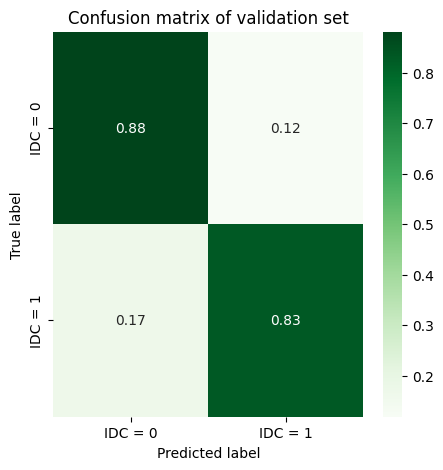

In [ ]:
# choose model
mn = 'logreg'

# plot
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix[mn][0], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

logreg averaged train/valid accuracy = 0.983/0.865
random_forest averaged train/valid accuracy = 0.915/0.902
extra_trees averaged train/valid accuracy = 0.914/0.905
gaussianNB averaged train/valid accuracy = 0.869/0.869


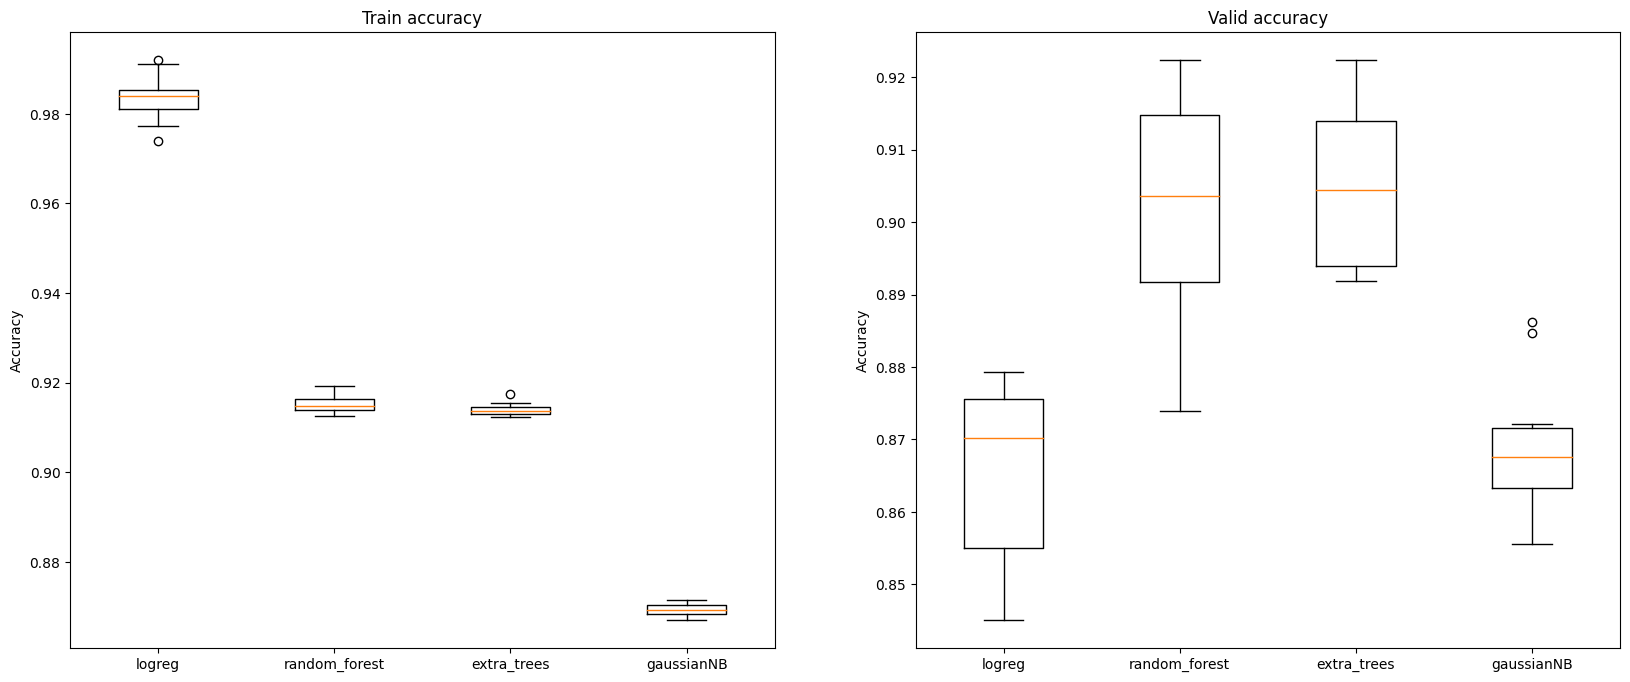

In [ ]:
# boxplot algorithm comparison
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
plt.title('Train accuracy')
plt.boxplot([train_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');

ax = fig.add_subplot(1,2,2)
plt.title('Valid accuracy')
plt.boxplot([valid_acc[mn] for mn in train_acc.keys()])
ax.set_xticklabels([mn for mn in train_acc.keys()])
ax.set_ylabel('Accuracy');

for mn in train_acc.keys():
    print(mn + ' averaged train/valid accuracy = %.3f/%.3f'%(np.mean(train_acc[mn]),
                                                             np.mean(valid_acc[mn])))

In [ ]:
## build the neural network class

class nn_class:
# class that implements the neural network

    # constructor
    def __init__(self, nn_name = 'tmp', log_step = 0.1, keep_prob = 0.33, mb_size = 50,
                 width = 50, height = 50, n_channel = 3, n_output = 2):

        # tunable hyperparameters for nn architecture
        self.s_f_conv1 = 3 # filter size of first convolution layer (default = 3)
        self.n_f_conv1 = 36 # number of features of first convolution layer (default = 36)
        self.s_f_conv2 = 3 # filter size of second convolution layer (default = 3)
        self.n_f_conv2 = 36 # number of features of second convolution layer (default = 36)
        self.s_f_conv3 = 3 # filter size of third convolution layer (default = 3)
        self.n_f_conv3 = 36 # number of features of third convolution layer (default = 36)
        self.n_n_fc1 = 576 # number of neurons of first fully connected layer (default = 576)
        self.n_channel = n_channel
        self.width = width
        self.height = height
        self.n_output = n_output

        # tunable hyperparameters for training
        self.mb_size = mb_size # mini batch size
        self.keep_prob = keep_prob # keeping probability with dropout regularization
        self.learn_rate_array = [10*1e-4, 7.5*1e-4, 5*1e-4, 2.5*1e-4, 1*1e-4, 1*1e-4,
                                 1*1e-4, 0.75*1e-4, 0.5*1e-4, 0.25*1e-4, 0.1*1e-4,
                                 0.1*1e-4, 0.075*1e-4,0.050*1e-4, 0.025*1e-4, 0.01*1e-4,
                                 0.0075*1e-4, 0.0050*1e-4,0.0025*1e-4,0.001*1e-4]
        self.learn_rate_step_size = 3 # in terms of epochs

        # helper variables
        self.learn_rate = self.learn_rate_array[0]
        self.learn_rate_pos = 0 # current position pointing to current learning rate
        self.index_in_epoch = 0
        self.current_epoch = 0
        self.log_step = log_step # log results in terms of epochs
        self.n_log_step = 0 # counting current number of mini batches trained on
        self.use_tb_summary = False # True = use tensorboard visualization
        self.use_tf_saver = False # True = use saver to save the model
        self.nn_name = nn_name # name of the neural network
        self.perm_array = np.array([]) # permutation array

    # function to get the next mini batch
    def next_mini_batch(self):

        start = self.index_in_epoch
        self.index_in_epoch += self.mb_size
        self.current_epoch += self.mb_size/len(self.x_train)

        # adapt length of permutation array
        if not len(self.perm_array) == len(self.x_train):
            self.perm_array = np.arange(len(self.x_train))

        # shuffle once at the start of epoch
        if start == 0:
            np.random.shuffle(self.perm_array)

        # at the end of the epoch
        if self.index_in_epoch > self.x_train.shape[0]:
            np.random.shuffle(self.perm_array) # shuffle data
            start = 0 # start next epoch
            self.index_in_epoch = self.mb_size # set index to mini batch size

            if self.train_on_augmented_data:
                # use augmented data for the next epoch
                self.x_train_aug = normalize_data(self.generate_images(self.x_train))
                self.y_train_aug = self.y_train

        end = self.index_in_epoch

        if self.train_on_augmented_data:
            # use augmented data
            x_tr = self.x_train_aug[self.perm_array[start:end]]
            y_tr = self.y_train_aug[self.perm_array[start:end]]
        else:
            # use original data
            x_tr = self.x_train[self.perm_array[start:end]]
            y_tr = self.y_train[self.perm_array[start:end]]

        return x_tr, y_tr

    # generate new images via rotations, translations, zoom using keras
    def generate_images(self, imgs):

        print('generate new set of images')

        # rotations, translations, zoom
        image_generator = keras.preprocessing.image.ImageDataGenerator(
            rotation_range = 10, width_shift_range = 0.1 , height_shift_range = 0.1,
            zoom_range = 0.1)

        # get transformed images
        imgs = image_generator.flow(imgs.copy(), np.zeros(len(imgs)),
                                    batch_size=len(imgs), shuffle = False).next()

        return imgs[0]

    # weight initialization
    def weight_variable(self, shape, name = None):
        initial = tf.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial, name = name)

    # bias initialization
    def bias_variable(self, shape, name = None):
        initial = tf.constant(0.1, shape=shape) #  positive bias
        return tf.Variable(initial, name = name)

    # 2D convolution
    def conv2d(self, x, W, name = None):
        return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name = name)

    # max pooling
    def max_pool_2x2(self, x, name = None):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                              padding='SAME', name = name)

    # attach summaries to a tensor for TensorBoard visualization
    def summary_variable(self, var, var_name):
        with tf.name_scope(var_name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('mean', mean)
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('max', tf.reduce_max(var))
            tf.summary.scalar('min', tf.reduce_min(var))
            tf.summary.histogram('histogram', var)

    # function to create the graph
    def create_graph(self):

        # reset default graph
        tf.reset_default_graph()

        # variables for input and output
        self.x_data_tf = tf.placeholder(dtype=tf.float32, shape=[None,self.height,
                                        self.width,self.n_channel], name='x_data_tf')
        self.y_data_tf = tf.placeholder(dtype=tf.float32, shape=[None, self.n_output],
                                        name='y_data_tf')

        # 1.layer: convolution + max pooling
        self.W_conv1_tf = self.weight_variable([self.s_f_conv1, self.s_f_conv1, self.n_channel,
                                                self.n_f_conv1], name='W_conv1_tf') # (3,3,3,36)
        self.b_conv1_tf = self.bias_variable([self.n_f_conv1], name = 'b_conv1_tf') # (36)
        self.h_conv1_tf = tf.nn.relu(self.conv2d(self.x_data_tf, self.W_conv1_tf)
                                     + self.b_conv1_tf, name = 'h_conv1_tf') # (.,50,50,36)
        self.h_pool1_tf = self.max_pool_2x2(self.h_conv1_tf,
                                            name = 'h_pool1_tf') # (.,25,25,36)

        # 2.layer: convolution + max pooling
        self.W_conv2_tf = self.weight_variable([self.s_f_conv2, self.s_f_conv2,
                                self.n_f_conv1, self.n_f_conv2], name = 'W_conv2_tf')
        self.b_conv2_tf = self.bias_variable([self.n_f_conv2], name = 'b_conv2_tf')
        self.h_conv2_tf = tf.nn.relu(self.conv2d(self.h_pool1_tf,
                        self.W_conv2_tf) + self.b_conv2_tf, name ='h_conv2_tf') #(.,25,25,36)
        self.h_pool2_tf = self.max_pool_2x2(self.h_conv2_tf, name = 'h_pool2_tf') #(.,13,13,36)

        # 3.layer: convolution + max pooling
        self.W_conv3_tf = self.weight_variable([self.s_f_conv3, self.s_f_conv3,
                        self.n_f_conv2, self.n_f_conv3], name = 'W_conv3_tf')
        self.b_conv3_tf = self.bias_variable([self.n_f_conv3], name = 'b_conv3_tf')
        self.h_conv3_tf = tf.nn.relu(self.conv2d(self.h_pool2_tf, self.W_conv3_tf) +
                                     self.b_conv3_tf, name ='h_conv3_tf') #(.,13,13,36)
        self.h_pool3_tf = self.max_pool_2x2(self.h_conv3_tf, name='h_pool3_tf') # (.,7,7,36)

        # 4.layer: fully connected
        self.W_fc1_tf = self.weight_variable([7*7*self.n_f_conv3, self.n_n_fc1],
                                             name='W_fc1_tf') # (7*7*36, 1024)
        self.b_fc1_tf = self.bias_variable([self.n_n_fc1], name = 'b_fc1_tf') # (1024)
        self.h_pool3_flat_tf = tf.reshape(self.h_pool3_tf, [-1,7*7*self.n_f_conv3],
                                          name = 'h_pool3_flat_tf') # (.,1024)
        self.h_fc1_tf = tf.nn.relu(tf.matmul(self.h_pool3_flat_tf,
                           self.W_fc1_tf) + self.b_fc1_tf, name = 'h_fc1_tf') # (.,1024)

        # add dropout
        self.keep_prob_tf = tf.placeholder(dtype=tf.float32, name = 'keep_prob_tf')
        self.h_fc1_drop_tf = tf.nn.dropout(self.h_fc1_tf, self.keep_prob_tf,
                                           name = 'h_fc1_drop_tf')

        # 5.layer: fully connected
        self.W_fc2_tf = self.weight_variable([self.n_n_fc1, self.n_output],
                                             name='W_fc2_tf') # (1024,1)
        self.b_fc2_tf = self.bias_variable([self.n_output], name='b_fc2_tf') # (1024)
        self.z_pred_tf = tf.add(tf.matmul(self.h_fc1_drop_tf, self.W_fc2_tf),
                                self.b_fc2_tf, name = 'z_pred_tf')# => (.,1)

        # cost function
        self.cross_entropy_tf = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            labels=self.y_data_tf, logits=self.z_pred_tf), name = 'cross_entropy_tf')

        # optimisation function
        self.learn_rate_tf = tf.placeholder(dtype=tf.float32, name="learn_rate_tf")
        self.train_step_tf = tf.train.AdamOptimizer(self.learn_rate_tf).minimize(
            self.cross_entropy_tf, name = 'train_step_tf')

        # predicted probabilities in one-hot encoding
        self.y_pred_proba_tf = tf.nn.softmax(self.z_pred_tf, name='y_pred_proba_tf')

        # tensor of correct predictions
        self.y_pred_correct_tf = tf.equal(tf.argmax(self.y_pred_proba_tf, 1),
                                          tf.argmax(self.y_data_tf, 1),
                                          name = 'y_pred_correct_tf')

        # accuracy
        self.accuracy_tf = tf.reduce_mean(tf.cast(self.y_pred_correct_tf, dtype=tf.float32),
                                         name = 'accuracy_tf')

        # tensors to save intermediate accuracies and losses during training
        self.train_loss_tf = tf.Variable(np.array([]), dtype=tf.float32,
                                         name='train_loss_tf', validate_shape = False)
        self.valid_loss_tf = tf.Variable(np.array([]), dtype=tf.float32,
                                         name='valid_loss_tf', validate_shape = False)
        self.train_acc_tf = tf.Variable(np.array([]), dtype=tf.float32,
                                        name='train_acc_tf', validate_shape = False)
        self.valid_acc_tf = tf.Variable(np.array([]), dtype=tf.float32,
                                        name='valid_acc_tf', validate_shape = False)

        # number of weights and biases
        num_weights = (self.s_f_conv1**2*self.n_f_conv1*self.n_channel
                       + self.s_f_conv2**2*self.n_f_conv1*self.n_f_conv2
                       + self.s_f_conv3**2*self.n_f_conv2*self.n_f_conv3
                       + 4*4*self.n_f_conv3*self.n_n_fc1 + self.n_n_fc1*self.n_output)
        num_biases = self.n_f_conv1 + self.n_f_conv2 + self.n_f_conv3 + self.n_n_fc1
        print('num_weights =', num_weights)
        print('num_biases =', num_biases)

        return None

    def attach_summary(self, sess):

        # create summary tensors for tensorboard
        self.use_tb_summary = True
        self.summary_variable(self.W_conv1_tf, 'W_conv1_tf')
        self.summary_variable(self.b_conv1_tf, 'b_conv1_tf')
        self.summary_variable(self.W_conv2_tf, 'W_conv2_tf')
        self.summary_variable(self.b_conv2_tf, 'b_conv2_tf')
        self.summary_variable(self.W_conv3_tf, 'W_conv3_tf')
        self.summary_variable(self.b_conv3_tf, 'b_conv3_tf')
        self.summary_variable(self.W_fc1_tf, 'W_fc1_tf')
        self.summary_variable(self.b_fc1_tf, 'b_fc1_tf')
        self.summary_variable(self.W_fc2_tf, 'W_fc2_tf')
        self.summary_variable(self.b_fc2_tf, 'b_fc2_tf')
        tf.summary.scalar('cross_entropy_tf', self.cross_entropy_tf)
        tf.summary.scalar('accuracy_tf', self.accuracy_tf)

        # merge all summaries for tensorboard
        self.merged = tf.summary.merge_all()

        # initialize summary writer
        timestamp = datetime.datetime.now().strftime('%d-%m-%Y_%H-%M-%S')
        filepath = os.path.join(os.getcwd(), 'logs', (self.nn_name+'_'+timestamp))
        self.train_writer = tf.summary.FileWriter(os.path.join(filepath,'train'), sess.graph)
        self.valid_writer = tf.summary.FileWriter(os.path.join(filepath,'valid'), sess.graph)

    def attach_saver(self):
        # initialize tensorflow saver
        self.use_tf_saver = True
        self.saver_tf = tf.train.Saver()

    # function to train the graph
    def train_graph(self, sess, x_train, y_train, x_valid, y_valid, n_epoch = 1,
                    train_on_augmented_data = False):

        # train on original or augmented data
        self.train_on_augmented_data = train_on_augmented_data

        # training and validation data
        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid

        # use augmented data
        if self.train_on_augmented_data:
            print('generate new set of images')
            self.x_train_aug = normalize_data(self.generate_images(self.x_train))
            self.y_train_aug = self.y_train

        # parameters
        mb_per_epoch = self.x_train.shape[0]/self.mb_size
        train_loss, train_acc, valid_loss, valid_acc = [],[],[],[]

        # start timer
        start = datetime.datetime.now();
        print(datetime.datetime.now().strftime('%d-%m-%Y %H:%M:%S'),': start training')
        print('learnrate =',self.learn_rate,', n_epoch =', n_epoch,
              ', mb_size =', self.mb_size, ', nn_name =', self.nn_name)
        # looping over mini batches
        for i in range(int(n_epoch*mb_per_epoch)+1):

            # adapt learn_rate
            if not self.learn_rate_pos == int(self.current_epoch // self.learn_rate_step_size):
                self.learn_rate_pos = int(self.current_epoch // self.learn_rate_step_size)
                self.learn_rate = self.learn_rate_array[self.learn_rate_pos]
                print(datetime.datetime.now()-start,': set learn rate to %.6f'%self.learn_rate)

            # get new batch
            x_batch, y_batch = self.next_mini_batch()

            # run the graph
            sess.run(self.train_step_tf, feed_dict={self.x_data_tf: x_batch,
                                                    self.y_data_tf: y_batch,
                                                    self.keep_prob_tf: self.keep_prob,
                                                    self.learn_rate_tf: self.learn_rate})
            # store losses and accuracies
            if i%int(self.log_step*mb_per_epoch) == 0 or i == int(n_epoch*mb_per_epoch):

                self.n_log_step += 1 # for logging the results

                feed_dict_train = {
                    self.x_data_tf: self.x_train[self.perm_array[:len(self.x_valid)]],
                    self.y_data_tf: self.y_train[self.perm_array[:len(self.y_valid)]],
                    self.keep_prob_tf: 1.0}

                feed_dict_valid = {self.x_data_tf: self.x_valid,
                                   self.y_data_tf: self.y_valid,
                                   self.keep_prob_tf: 1.0}

                # summary for tensorboard
                if self.use_tb_summary:
                    train_summary = sess.run(self.merged, feed_dict = feed_dict_train)
                    valid_summary = sess.run(self.merged, feed_dict = feed_dict_valid)
                    self.train_writer.add_summary(train_summary, self.n_log_step)
                    self.valid_writer.add_summary(valid_summary, self.n_log_step)

                train_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_train))

                train_acc.append(self.accuracy_tf.eval(session = sess,
                                                       feed_dict = feed_dict_train))

                valid_loss.append(sess.run(self.cross_entropy_tf,
                                           feed_dict = feed_dict_valid))

                valid_acc.append(self.accuracy_tf.eval(session = sess,
                                                       feed_dict = feed_dict_valid))

                print('%.2f epoch: train/val loss = %.4f/%.4f, train/val acc = %.4f/%.4f'%(
                    self.current_epoch, train_loss[-1], valid_loss[-1],
                    train_acc[-1], valid_acc[-1]))

        # concatenate losses and accuracies and assign to tensor variables
        tl_c = np.concatenate([self.train_loss_tf.eval(session=sess), train_loss], axis = 0)
        vl_c = np.concatenate([self.valid_loss_tf.eval(session=sess), valid_loss], axis = 0)
        ta_c = np.concatenate([self.train_acc_tf.eval(session=sess), train_acc], axis = 0)
        va_c = np.concatenate([self.valid_acc_tf.eval(session=sess), valid_acc], axis = 0)

        sess.run(tf.assign(self.train_loss_tf, tl_c, validate_shape = False))
        sess.run(tf.assign(self.valid_loss_tf, vl_c , validate_shape = False))
        sess.run(tf.assign(self.train_acc_tf, ta_c , validate_shape = False))
        sess.run(tf.assign(self.valid_acc_tf, va_c , validate_shape = False))

        print('running time for training: ', datetime.datetime.now() - start)
        return None

    # save tensors/summaries
    def save_model(self, sess):

        # tf saver
        if self.use_tf_saver:
            #filepath = os.path.join(os.getcwd(), 'logs' , self.nn_name)
            filepath = os.path.join(os.getcwd(), self.nn_name)
            self.saver_tf.save(sess, filepath)

        # tb summary
        if self.use_tb_summary:
            self.train_writer.close()
            self.valid_writer.close()

        return None

    # forward prediction of current graph
    def forward(self, sess, x_data):
        y_pred_proba = self.y_pred_proba_tf.eval(session = sess,
                                                 feed_dict = {self.x_data_tf: x_data,
                                                              self.keep_prob_tf: 1.0})
        return y_pred_proba

    # function to load tensors from a saved graph
    def load_tensors(self, graph):

        # input tensors
        self.x_data_tf = graph.get_tensor_by_name("x_data_tf:0")
        self.y_data_tf = graph.get_tensor_by_name("y_data_tf:0")

        # weights and bias tensors
        self.W_conv1_tf = graph.get_tensor_by_name("W_conv1_tf:0")
        self.W_conv2_tf = graph.get_tensor_by_name("W_conv2_tf:0")
        self.W_conv3_tf = graph.get_tensor_by_name("W_conv3_tf:0")
        self.W_fc1_tf = graph.get_tensor_by_name("W_fc1_tf:0")
        self.W_fc2_tf = graph.get_tensor_by_name("W_fc2_tf:0")
        self.b_conv1_tf = graph.get_tensor_by_name("b_conv1_tf:0")
        self.b_conv2_tf = graph.get_tensor_by_name("b_conv2_tf:0")
        self.b_conv3_tf = graph.get_tensor_by_name("b_conv3_tf:0")
        self.b_fc1_tf = graph.get_tensor_by_name("b_fc1_tf:0")
        self.b_fc2_tf = graph.get_tensor_by_name("b_fc2_tf:0")

        # activation tensors
        self.h_conv1_tf = graph.get_tensor_by_name('h_conv1_tf:0')
        self.h_pool1_tf = graph.get_tensor_by_name('h_pool1_tf:0')
        self.h_conv2_tf = graph.get_tensor_by_name('h_conv2_tf:0')
        self.h_pool2_tf = graph.get_tensor_by_name('h_pool2_tf:0')
        self.h_conv3_tf = graph.get_tensor_by_name('h_conv3_tf:0')
        self.h_pool3_tf = graph.get_tensor_by_name('h_pool3_tf:0')
        self.h_fc1_tf = graph.get_tensor_by_name('h_fc1_tf:0')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')

        # training and prediction tensors
        self.learn_rate_tf = graph.get_tensor_by_name("learn_rate_tf:0")
        self.keep_prob_tf = graph.get_tensor_by_name("keep_prob_tf:0")
        self.cross_entropy_tf = graph.get_tensor_by_name('cross_entropy_tf:0')
        self.train_step_tf = graph.get_operation_by_name('train_step_tf')
        self.z_pred_tf = graph.get_tensor_by_name('z_pred_tf:0')
        self.y_pred_proba_tf = graph.get_tensor_by_name("y_pred_proba_tf:0")
        self.y_pred_correct_tf = graph.get_tensor_by_name('y_pred_correct_tf:0')
        self.accuracy_tf = graph.get_tensor_by_name('accuracy_tf:0')

        # tensor of stored losses and accuricies during training
        self.train_loss_tf = graph.get_tensor_by_name("train_loss_tf:0")
        self.train_acc_tf = graph.get_tensor_by_name("train_acc_tf:0")
        self.valid_loss_tf = graph.get_tensor_by_name("valid_loss_tf:0")
        self.valid_acc_tf = graph.get_tensor_by_name("valid_acc_tf:0")

        return None

    # get losses of training and validation sets
    def get_loss(self, sess):
        train_loss = self.train_loss_tf.eval(session = sess)
        valid_loss = self.valid_loss_tf.eval(session = sess)
        return train_loss, valid_loss

    # get accuracies of training and validation sets
    def get_accuracy(self, sess):
        train_acc = self.train_acc_tf.eval(session = sess)
        valid_acc = self.valid_acc_tf.eval(session = sess)
        return train_acc, valid_acc

    # get weights
    def get_weights(self, sess):
        W_conv1 = self.W_conv1_tf.eval(session = sess)
        W_conv2 = self.W_conv2_tf.eval(session = sess)
        W_conv3 = self.W_conv3_tf.eval(session = sess)
        W_fc1_tf = self.W_fc1_tf.eval(session = sess)
        W_fc2_tf = self.W_fc2_tf.eval(session = sess)
        return W_conv1, W_conv2, W_conv3, W_fc1_tf, W_fc2_tf

    # get biases
    def get_biases(self, sess):
        b_conv1 = self.b_conv1_tf.eval(session = sess)
        b_conv2 = self.b_conv2_tf.eval(session = sess)
        b_conv3 = self.b_conv3_tf.eval(session = sess)
        b_fc1_tf = self.b_fc1_tf.eval(session = sess)
        b_fc2_tf = self.b_fc2_tf.eval(session = sess)
        return b_conv1, b_conv2, b_conv3, b_fc1_tf, b_fc2_tf

    # load session from file, restore graph, and load tensors
    def load_session_from_file(self, filename):
        tf.reset_default_graph()
        filepath = os.path.join(os.getcwd(), filename + '.meta')
        #filepath = os.path.join(os.getcwd(),'logs', filename + '.meta')
        saver = tf.train.import_meta_graph(filepath)
        print(filepath)
        sess = tf.Session()
        saver.restore(sess, mn)
        graph = tf.get_default_graph()
        self.load_tensors(graph)
        return sess

    # receive activations given the input
    def get_activations(self, sess, x_data):
        feed_dict = {self.x_data_tf: x_data, self.keep_prob_tf: 1.0}
        h_conv1 = self.h_conv1_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool1 = self.h_pool1_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv2 = self.h_conv2_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool2 = self.h_pool2_tf.eval(session = sess, feed_dict = feed_dict)
        h_conv3 = self.h_conv3_tf.eval(session = sess, feed_dict = feed_dict)
        h_pool3 = self.h_pool3_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc1 = self.h_fc1_tf.eval(session = sess, feed_dict = feed_dict)
        h_fc2 = self.z_pred_tf.eval(session = sess, feed_dict = feed_dict)
        return h_conv1,h_pool1,h_conv2,h_pool2,h_conv3,h_pool3,h_fc1,h_fc2

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
nn_name = ['nn0','nn1','nn2','nn3','nn4','nn5','nn6','nn7','nn8','nn9']

# cross validations
cv_num = 10 # cross validations default = 20 => 5% validation set
kfold = sklearn.model_selection.KFold(cv_num, shuffle=True, random_state=123)

for i,(train_index, valid_index) in enumerate(kfold.split(x_train_valid)):

    # start timer
    start = datetime.datetime.now();

    # train and validation data of original images
    x_train = x_train_valid[train_index]
    y_train = y_train_valid[train_index]
    x_valid = x_train_valid[valid_index]
    y_valid = y_train_valid[valid_index]

    # create neural network graph
    nn_graph = nn_class(nn_name = nn_name[i]) # instance of nn_class
    nn_graph.create_graph() # create graph
    nn_graph.attach_saver() # attach saver tensors
    with tf.Session() as sess:

        # attach summaries
        nn_graph.attach_summary(sess)

        # variable initialization of the default graph
        sess.run(tf.global_variables_initializer())

        # training on original data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 1.)

        # training on augmented data
        nn_graph.train_graph(sess, x_train, y_train, x_valid, y_valid, n_epoch = 29.,
                             train_on_augmented_data = True)

        # save tensors and summaries of model
        nn_graph.save_model(sess)

    break

print('total running time for training: ', datetime.datetime.now() - start)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



num_weights = 357228
num_biases = 684
10-04-2024 07:40:31 : start training
learnrate = 0.001 , n_epoch = 1.0 , mb_size = 50 , nn_name = nn0
0.01 epoch: train/val loss = 4.0961/3.9663, train/val acc = 0.5279/0.5423
0.10 epoch: train/val loss = 0.6024/0.6186, train/val acc = 0.4937/0.4937
0.19 epoch: train/val loss = 0.2633/0.2864, train/val acc = 0.9153/0.9027
0.28 epoch: train/val loss = 0.2502/0.2830, train/val acc = 0.8901/0.8901
0.37 epoch: train/val loss = 0.2934/0.2928, train/val acc = 0.9279/0.9225
0.46 epoch: train/val loss = 0.2230/0.2391, train/val acc = 0.9135/0.9099
0.55 epoch: train/val loss = 0.2246/0.2410, train/val acc = 0.9153/0.8991
0.64 epoch: train/val loss = 0.2263/0.2428, train/val acc = 0.9315/0.9171
0.73 epoch: train/val loss = 0.2341/0.2427, train/val acc = 0.9315/0.9243
0.82 epoch: train/val loss = 0.2452/0.2467, train/val acc = 0.9279/0.9243
0.91 epoch: train/val loss = 0.2125/0.2206, train/val acc = 0.9297/0.9225
1.00 epoch: train/val loss = 0.2056/0.2139, tr

In [ ]:
## visualization with tensorboard
if False:
    !tensorboard --logdir=./logs

/content/nn0.meta
final train/valid loss = 0.1880/0.1755, train/valid accuracy = 0.9315/0.9315


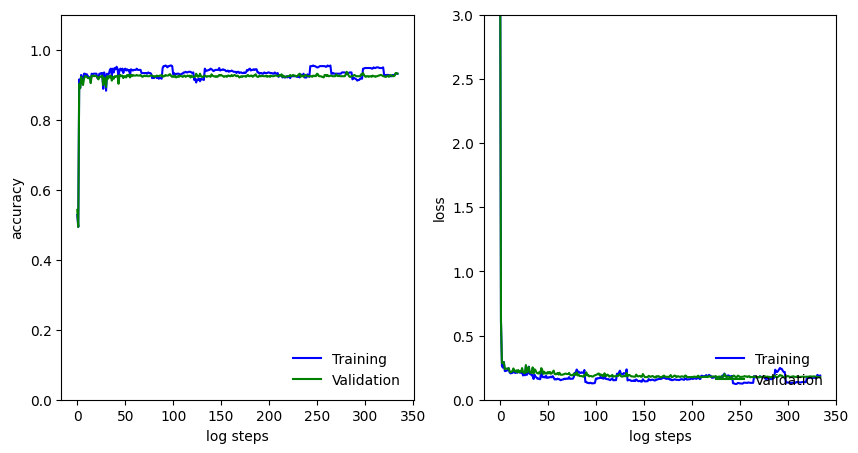

In [ ]:
## loss and accuracy curves

# choose neural network
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
train_loss[mn], valid_loss[mn] = nn_graph.get_loss(sess)
train_acc[mn], valid_acc[mn] = nn_graph.get_accuracy(sess)
sess.close()

print('final train/valid loss = %.4f/%.4f, train/valid accuracy = %.4f/%.4f'%(
    train_loss[mn][-1], valid_loss[mn][-1], train_acc[mn][-1], valid_acc[mn][-1]))

plt.figure(figsize=(10, 5));
plt.subplot(1,2,1);
plt.plot(np.arange(0,len(train_acc[mn])), train_acc[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_acc[mn])), valid_acc[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 1.1, ymin = 0.0)
plt.ylabel('accuracy')
plt.xlabel('log steps');

plt.subplot(1,2,2)
plt.plot(np.arange(0,len(train_loss[mn])), train_loss[mn],'-b', label='Training')
plt.plot(np.arange(0,len(valid_loss[mn])), valid_loss[mn],'-g', label='Validation')
plt.legend(loc='lower right', frameon=False)
plt.ylim(ymax = 3.0, ymin = 0.0)
plt.ylabel('loss')
plt.xlabel('log steps');

/content/nn0.meta


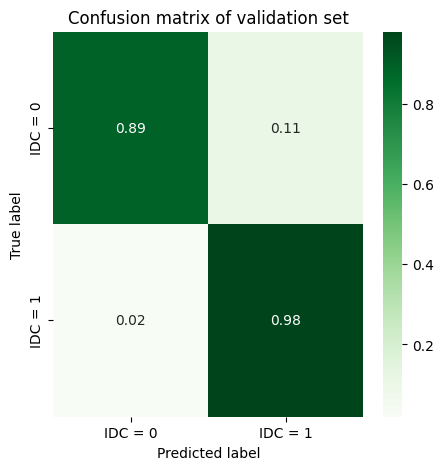

In [ ]:
## show confusion matrix

# choose neural network
mn = nn_name[0]
nn_graph = nn_class()
sess = nn_graph.load_session_from_file(mn)
y_valid_pred[mn] = nn_graph.forward(sess, x_valid)
sess.close()

# confusion matrix
cnf_valid_matrix['neural_network'] = sklearn.metrics.confusion_matrix(
    y_pred = one_hot_to_dense(y_valid_pred[mn]),
    y_true = one_hot_to_dense(y_valid)).astype(np.float32)

# normalize
cnf_valid_matrix['neural_network'][0,:] = cnf_valid_matrix['neural_network'][0,:]/cnf_valid_matrix['neural_network'][0,:].sum()
cnf_valid_matrix['neural_network'][1,:] = cnf_valid_matrix['neural_network'][1,:]/cnf_valid_matrix['neural_network'][1,:].sum()

# plot
labels_array = ['IDC = 0', 'IDC = 1']
fig, ax = plt.subplots(1,figsize=(5,5))
ax = sns.heatmap(cnf_valid_matrix['neural_network'], ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(labels_array)
ax.set_yticklabels(labels_array)
plt.title('Confusion matrix of validation set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();